In [74]:
import _nb_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
from config import CONFIG
from prompter import *
from data import *
from utils import *
from model import GenParams, GoogleAIStudioMLLM, OllamaMLLM
from viz import display_prompt

In [76]:
model_name = "gemma3:4b-it-qat"

llm = OllamaMLLM(model_name)

In [77]:
by_model = "LRASPP_MobileNet_V3"

In [78]:
gen_params = GenParams(
    seed=CONFIG["seed"],
    temperature=0.1
)

In [79]:
prompt_blueprint={
        "context": "default",
        "color_map": "default",
        "input_format": "sep_ovr_original",
        "task": "default",
        "output_format": "default",
        "support_set_intro": "default",
        "support_set_item": "default",
        "query": "default",
}

In [80]:
fast_prompt_builder = FastPromptBuilder(
    seed=CONFIG["seed"],
    prompt_blueprint=prompt_blueprint,
    by_model=by_model,
    sup_set_img_idxs=[16, 2, 18],
    str_formats=None,
    alpha=0.6,
    prs_mask_paths=get_mask_prs_path(by_model=by_model),
    jsonl_save_path=None
)

In [81]:
cs_inference_prompts = fast_prompt_builder.build_cs_inference_prompts(range(0, 80))
len(cs_inference_prompts)

147

I am in a binary semantic segmentation context and I want to compare a **prediction** mask with a **ground truth** mask, both segmented over the same **scene**.


In both masks, a color-class mapping is applied: the white color is mapped to the AEROPLANE class, while the black color refers to unlabelled classes.


I will give you two images: the first image is the ground truth mask, the second image is the prediction mask.
Both images are overlaid with the scene to support your analysis.


## Instructions

Your task is to find where and how the prediction deviates from the ground truth. Assume the ground truth to be correct. If there are no significant deviations, simply say it.


I provide some examples of correct outputs:
- "Overall, the prediction captured most of the ground truth regions, however, the ground truth SKY region on the top left of the scene has been segmented quite coarsely, some details are missed, while the prediction mask of the ground truth MOUNTAIN region on the center of the scene is incomplete."
- "The prediction mask is quite chaotic, many GRASS regions have been hallucinated all over the scene, while the TREE region has been over-extended towards the top."
- "The ground truth WATER region on the bottom has been segmented with a coarse, irregular shape, especially on the boundary."


To help you, I will give you a set of example images, each associated with an ideal answer, which might mention classes whose names are irrelevant to your problem.


EXAMPLE 1.

Input:

Ground Truth.

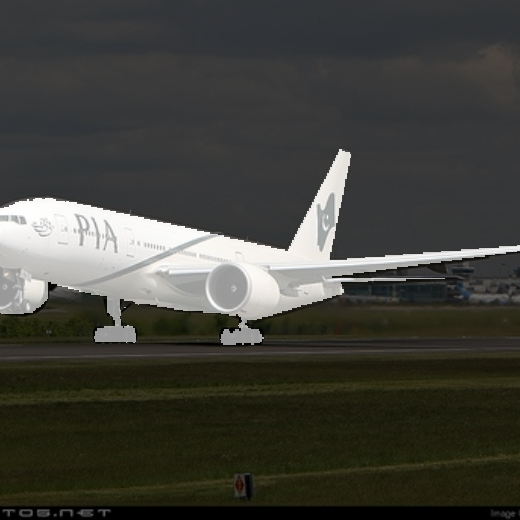

Prediction.

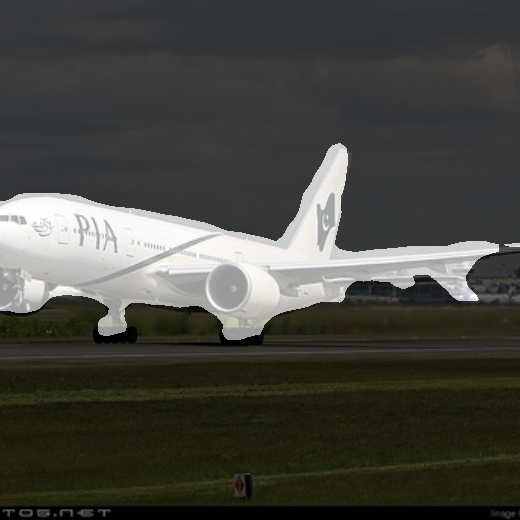

Output:

The ground truth AEROPLANE region has been segmented quite well by the prediction, but the boundaries are imprecise and less defined.

EXAMPLE 2.

Input:

Ground Truth.

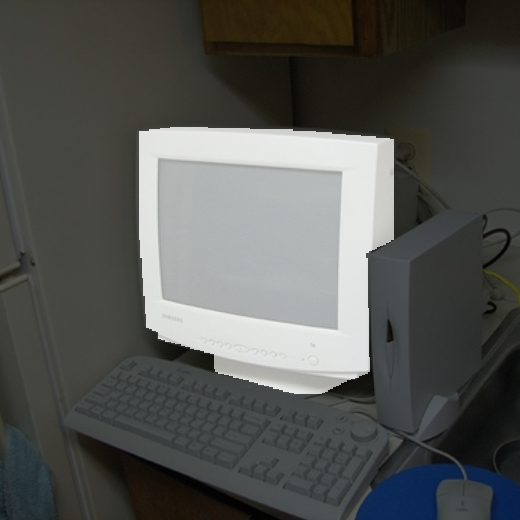

Prediction.

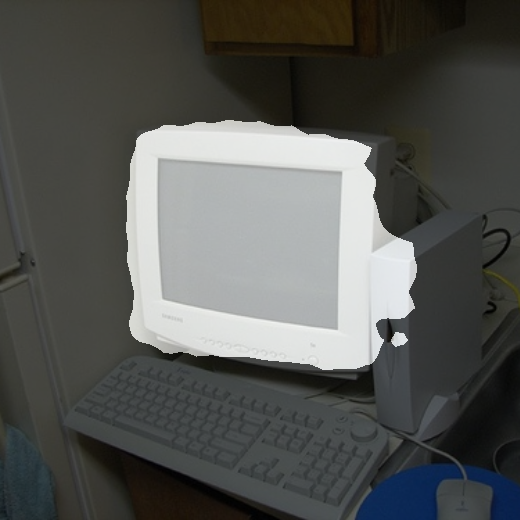

Output:

The boundaries of the ground truth TVMONITOR region are more imprecise and irregular.

EXAMPLE 3.

Input:

Ground Truth.

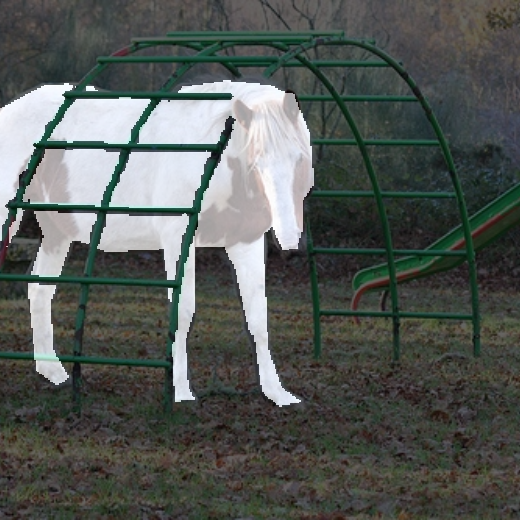

Prediction.

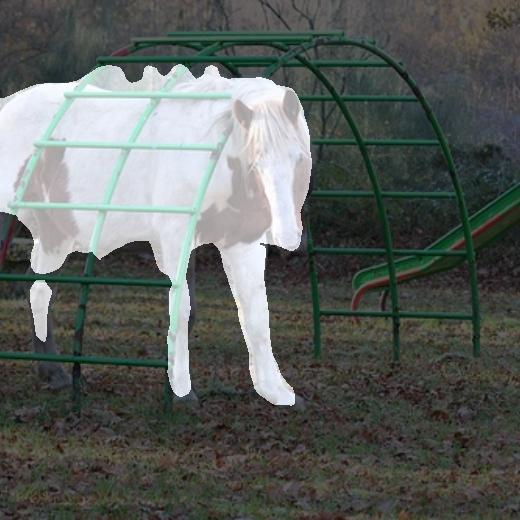

Output:

The prediction mask of the ground truth HORSE region is decent, but rougher, more irregular, some area within the region has been over-segmented and some area has been under-segmented on the bottom-left.

Now, I ask you to generate the output based on the following input. Remember the considered class is the AEROPLANE class, reference it explicitely in the answer.


Input:

Ground Truth.

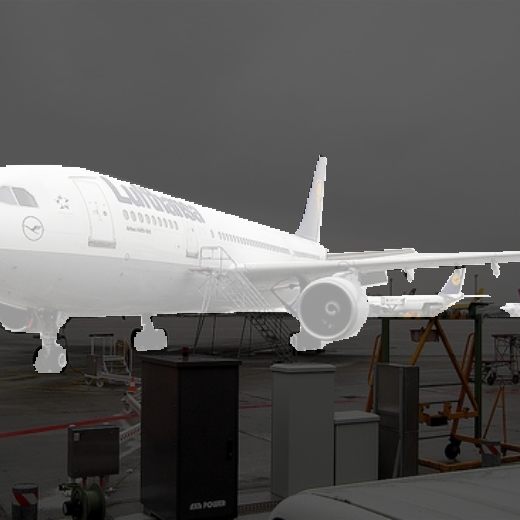

Prediction.

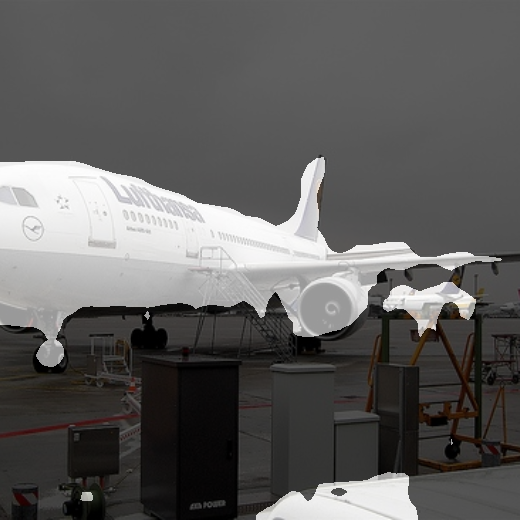

Output:

In [41]:
display_prompt(cs_inference_prompts[2])

In [10]:
query_uids = image_UIDs[[0, 1]]
gts_paths = [GTS_PATH / (UID + ".png") for UID in query_uids]
gts = torch.stack([get_gt(p, class_map=CLASS_MAP, resize_size=CONFIG['seg']['image_size'], center_crop=True) for p in gts_paths])

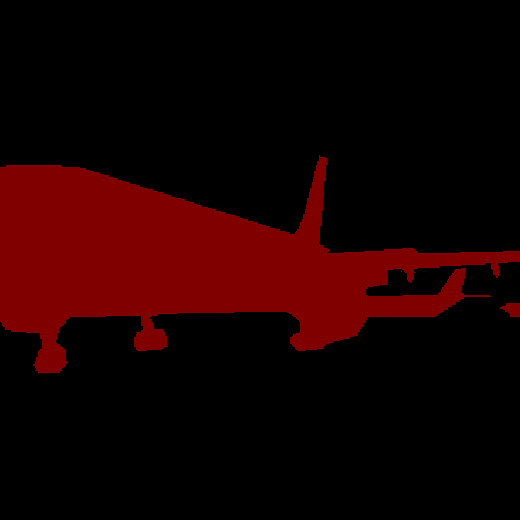

In [13]:
display(to_pil_image(apply_colormap(gts, COLOR_MAP_DICT)[1]))

## Single Sample

In [24]:
seed_idxs = [0, 1, 2, 4, 5]
query_idxs = [0, 1, 2, 4, 5]

In [ ]:
seeds = [str(get_one_answer_gt(by_model=by_model, idx=i, return_state=False)) for i in seed_idxs] 
data_gen_prompt_builder.build_data_gen_prompt(prompt_blueprint, seeds=seeds, num_outputs=5)

['You are an expert in evaluating the quality of textual descriptions of predictions produced against ground truth.\n',
 "Your task is to generate synthetic data <text, score> pairs, in which :\n- 'text' describes how well a prediction aligns with a ground truth.\n- 'score' (integer in the range [1, 5], the higher the better) indicating the quality of that prediction based on 'text'.\n",
 "Your output should be a JSON array of objects containing the 'text' and 'score' field.",
 'Here are a few examples of the desired output:\n',
 "{0: 'The ground truth AEROPLANE regions have been segmented in a coarser and incomplete way, especially regarding the wings, and two tiny AEROPLANE patches have been hallucinated on the right edge. The prediction mask for the ground truth PERSON region on the center-bottom-left is slightly more blob-like.\\n'}",
 '\n',
 "{1: 'The ground truth AEROPLANE regions have been captured with irregular and erratic boundaries, while some AEROPLANE area has been halluci

In [10]:
await data_gen_prompt_builder.generate_one_sample(
    model=llm,
    gen_params=gen_params,
    query_idxs=query_idxs,
    seed_idxs=seed_idxs
)

Wrong parsing to dict!
{'img_idx': [0, 1, 2, 4, 5], 'content': '{\n    "0": "The predicted bounding box for the ground truth BUILDING region is noticeably larger than the actual area, and the surrounding context is incorrectly labeled as ROAD. The edges of the predicted region appear somewhat diffuse, particularly at the top.\\n"\n  },\n  {\n    "1": "While the prediction mostly aligns with the ground truth VEHICLE region, there\'s a small but significant area of the predicted mask that extends beyond the true boundary, creating an \'over-prediction\'. The color segmentation is generally accurate, but some minor misclassifications of small elements as BACKGROUND exist.\\n"\n  },\n  {\n    "2": "The ground truth PLANT region\'s boundaries are sharply defined, but the prediction contains a substantial amount of false positives – specifically, regions of the background have been incorrectly labeled as PLANT. The prediction mask is significantly less detailed and has a higher level of nois